## データサイエンス特論2024: Lecture14 LLM時代のデータサイエンスとは
### イントロ：LocalなLLMでcsvデータを分析してみる。

>【注意】この環境は2024.5月に動作確認したものであり、利用するソフトのバージョンアップで使えなくなる可能性が高いことに注意。

ここでは、LLM(大規模言語モデル）を使って、csvファイルに記録されたデータを分析する例を示します。最先端のLLMの活用方法として、データに直接質問(query)するパターンと、データ分析エージェント(Agent)を使って分析させるパターンの２種類を紹介します。

OpenAIなどの有料の高性能LLMを使わなくても、最近はオープンソースのLLMでもcsvデータ分析ぐらいはできるものが増えてきました。試してみると面白と思います。

最初に、オープンソースのLLMを利用する例を、最後に参考までに、OpenAIを使う場合を示します。


オープンソースLLMを利用する方法として、ここでは、いったんローカル環境(といってもcolaboratory計算機ですが）にLLMをダウンロードして利用するローカルLLMを利用します。情報が外部に漏れることを気にする方はローカルLLMは便利ですね。ここではOllamaというソフトウエアを用いて、オープンソースのLLMをローカル環境にダウンロードして活用します。

OpenAIのAPIアカウントをお持ちの方は、gpt3やgpt4をLLMとして使うと、違いが実感できるはずです。

llamaindexの pandas query engineを使います。

- https://docs.llamaindex.ai/en/stable/examples/query_engine/pandas_query_engine/?h=titanic#analyzing-the-titanic-dataset




###  利用環境
- [Ollama](https://ollama.com/)
- [llama_index](https://docs.llamaindex.ai/en/stable/)
- [langchain](https://python.langchain.com/docs/get_started/introduction)

以下gemini様の説明より
> LlamaIndexとLangChainは、どちらも大規模言語モデル（LLM）を活用するための強力なライブラリですが、<略>
> LlamaIndexはQAシステムやデータインデックス作成に特化し、初心者でも扱いやすい簡潔さが魅力。一方、LangChainは汎用性の高いLLMフレームワークで、複雑なタスクや高度なカスタマイズにも対応。それぞれの強みを活かし、目的に合ったツールを選ぶことで、LLM活用の可能性が大きく広がります。

以下copilot様より、、
> Ollamaは、ユーザーがローカル環境で大規模な言語モデルを簡単に動作させることができるツールです。LLama2やCode Llamaなどのモデルを実行することができ、カスタマイズや独自のモデルの作成も可能です

## 2. Ollamaの設定
ここでは、ollamaを colaboratoryの環境にダウンロードしてインストールします、インストールは１回でいいです。

In [1]:
!curl -fsSL https://ollama.com/install.sh | sh
!sudo apt install -y neofetch

>>> Downloading ollama...
############################################################################################# 100.0%
>>> Installing ollama to /usr/local/bin...
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  caca-utils chafa fonts-droid-fallback fonts-noto-mono fonts-urw-base35
  ghostscript gsfonts imagemagick imagemagick-6-common imagemagick-6.q16 jp2a
  libchafa0 libdjvulibre-text libdjvulibre21 libfftw3-double3 libgs9
  libgs9-common libid3tag0 libidn12 libijs-0.35 libimlib2 libjbig2dec0
  libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6
  libmagickcore-6.q16-6-extra libmagickwand-6.q16-6 libnetpbm10 libp

マシンスペックを確認します。

In [2]:
!neofetch

            .-/+oossssoo+/-.
        `:+ssssssssssssssssss+:`
      -+ssssssssssssssssssyyssss+-
    .ossssssssssssssssssdMMMNysssso.
   /ssssssssssshdmmNNmmyNMMMMhssssss/
  +ssssssssshmydMMMMMMMNddddyssssssss+
 /sssssssshNMMMyhhyyyyhmNMMMNhssssssss/
.ssssssssdMMMNhsssssssssshNMMMdssssssss.
+sssshhhyNMMNyssssssssssssyNMMMysssssss+
ossyNMMMNyMMhsssssssssssssshmmmhssssssso
ossyNMMMNyMMhsssssssssssssshmmmhssssssso
+sssshhhyNMMNyssssssssssssyNMMMysssssss+
.ssssssssdMMMNhsssssssssshNMMMdssssssss.
 /sssssssshNMMMyhhyyyyhdNMMMNhssssssss/
  +sssssssssdmydMMMMMMMMddddyssssssss+
   /ssssssssssshdmNNNNmyNMMMMhssssss/
    .ossssssssssssssssssdMMMNysssso.
      -+sssssssssssssssssyyyssss+-
        `:+ssssssssssssssssss+:`
            .-/+oossssoo+/-.
root@f5b10f3b1845 
----------------- 
OS: Ubuntu 22.04.3 LTS x86_64 
Host: Google Compute Engine 
Kernel: 6.1.58+ 
Uptime: 11 mins 
Packages: 1300 (dpkg) 
Shell: bash 5.1.16 
Terminal: jupyter-noteboo 
CPU: Intel Xeon (8) @ 2.199GHz 
GPU: NVIDIA Tesla 

### ollama serverを起動

colab環境にてollamaを使うためのサーバーを起動します。このサーバーは、外部から(pythonなどから）ollamaが管理するllmにアクセスるためのサーバーでもあります。

ローカルLLMを使っていて、時々以下のようなエラーが出る場合は、ollama severが停止している可能性があるので、↓のセルをもう一度起動しましょう。

> ConnectError: [Errno 99] Cannot assign requested address

In [187]:
import subprocess
import time

# Start ollama as a backrgound process
command = "nohup ollama serve&"

# Use subprocess.Popen to start the process in the background
process = subprocess.Popen(command,
                            shell=True,
                           stdout=subprocess.PIPE,
                           stderr=subprocess.PIPE)
print("Process ID:", process.pid)
time.sleep(5)  # Makes Python wait for 5 seconds

Process ID: 29975


### ここでollamaでモデルをダウンロードしてrunします。


- 途中で落ちると、ollamaのプロセスが落ちるだけなので、そこだけ再起動すればよい、HDDにpullした結果が残っている？ので、再起動すると、すでにpullしたものはそのまま使えます。

```
# これはコードとして書式設定されます
ollama run mistral
ollama run llama3
ollama run phi3
```



8B(ビリオン、80億パラメター）モデルならば、Colab環境でどうにか動きます。

とりあえず、mistralが優秀なのでこれを使います、他のllmも試すとよいと思います。

In [166]:
OLLAMA_MODEL='gemma:7b'
OLLAMA_MODEL='mistral'
#OLLAMA_MODEL='phi3'
#OLLAMA_MODEL='llama3'
#OLLAMA_MODEL='wizardlm2'

# Set it at the OS level
import os
os.environ['OLLAMA_MODEL'] = OLLAMA_MODEL
!echo $OLLAMA_MODEL

mistral


以下では、"run"コマンドにより、指定したローカルLLMをダウンロードして、実行しています。一度ダウンロードすると、セッションが終了するまでずっと使えます。

In [34]:
!ollama run $OLLAMA_MODEL "Explain AI in one line"

ストリーミング出力は最後の 5000 行に切り捨てられました。
verifying sha256 digest ⠹ pulling manifest 
pulling e9e56e8bb5f0... 100% ▕▏  26 GB                         
pulling 43070e2d4e53... 100% ▕▏  11 KB                         
pulling 79b7eca19f7a... 100% ▕▏   43 B                         
pulling ed11eda7790d... 100% ▕▏   30 B                         
pulling 9dec05e9b2db... 100% ▕▏  484 B                         
verifying sha256 digest ⠸ pulling manifest 
pulling e9e56e8bb5f0... 100% ▕▏  26 GB                         
pulling 43070e2d4e53... 100% ▕▏  11 KB                         
pulling 79b7eca19f7a... 100% ▕▏   43 B                         
pulling ed11eda7790d... 100% ▕▏   30 B                         
pulling 9dec05e9b2db... 100% ▕▏  484 B                         
verifying sha256 digest ⠼ pulling manifest 
pulling e9e56e8bb5f0... 100% ▕▏  26 GB                         
pulling 43070e2d4e53... 100% ▕▏  11 KB                         
pulling 79b7eca19f7a... 100% ▕▏   43 B                         
pull

In [6]:
!pip install --quiet -U langchain langchainhub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.6/867.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 19.5 MB/s eta 0:00:00


ちゃんと動くかどうかを、確かめます。

In [167]:
from langchain_community.chat_models import ChatOllama

#OLLAMA_MODEL='mistral'
llm = ChatOllama(model=OLLAMA_MODEL)

llm.invoke("Who are you?")

AIMessage(content=" I am a large language model developed by Mistral AI. I am designed to generate human-like text based on the inputs I receive. I don't have the ability to have experiences, emotions or sensations, and I don't have a physical presence. I exist solely as a program running on computers. My main goal is to assist and provide information to users through text-based interaction. How can I help you today?", response_metadata={'model': 'mistral', 'created_at': '2024-05-05T23:18:48.177431949Z', 'message': {'role': 'assistant', 'content': ''}, 'done': True, 'total_duration': 5285116545, 'load_duration': 2910535801, 'prompt_eval_count': 13, 'prompt_eval_duration': 221653000, 'eval_count': 89, 'eval_duration': 2029391000}, id='run-3eb13f28-093a-4129-a5bc-7c1f24242928-0')

# ここから本番です。

In [8]:
!pip install llama-index llama-index-experimental llama-index-llms-ollama

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 92.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.9/312.9 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.5 MB/s eta 0:00:00


## まずは、簡単なDataFrame に対して、質問(query)を投げるパターンでの利用です。
- llamaindexというLLMを活用するpython パッケージを利用しています。
- llamaindexから、バックグラウンドで動いている、Ollamaモデルに接続する形でLLMを利用できます。


In [9]:
import logging
import sys
from IPython.display import Markdown, display

import pandas as pd
from llama_index.experimental.query_engine import PandasQueryEngine


logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

In [168]:
from llama_index.core import Settings
from llama_index.llms.ollama import Ollama

Settings.llm = Ollama(model=OLLAMA_MODEL, request_timeout=30.0)

もっとも簡単な例で、DataFrameに対する質問をしてみます。

In [169]:
# Test on some sample data
df = pd.DataFrame(
    {
        "city": ["Toronto", "Tokyo", "Berlin"],
        "population": [2930000, 13960000, 3645000],
    }
)

In [170]:
query_engine = PandasQueryEngine(df=df, verbose=True)

In [171]:
response = query_engine.query(
    "What is the name of the city with the highest population?",
)

> Pandas Instructions:
```
 df['city'][df['population'].idxmax()]
```
> Pandas Output: Tokyo


## ここから、いよいよtitanicに

In [57]:
!wget 'https://raw.githubusercontent.com/jerryjliu/llama_index/main/docs/docs/examples/data/csv/titanic_train.csv' -O 'titanic_train.csv'

--2024-05-05 22:46:21--  https://raw.githubusercontent.com/jerryjliu/llama_index/main/docs/docs/examples/data/csv/titanic_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57726 (56K) [text/plain]
Saving to: ‘titanic_train.csv’

titanic_train.csv   100%[===================>]  56.37K  --.-KB/s    in 0.007s  

2024-05-05 22:46:22 (7.56 MB/s) - ‘titanic_train.csv’ saved [57726/57726]



In [172]:
df = pd.read_csv("./titanic_train.csv" )
df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [173]:
query_engine = PandasQueryEngine(df=df, verbose=True)

In [174]:
response = query_engine.query(
    "What is the correlation between survival and age?",
)

> Pandas Instructions:
```
 df['survived'].corr(df['age'])
```
> Pandas Output: -0.07722109457217768


sqrtがないとかいってエラーになりる場合もありますが、何回か動かしているとうまく計算できるかも。

In [175]:
response = query_engine.query(
    "whats the square root of the average age?" ,
)

> Pandas Instructions:
```
 df['age'].mean().sqrt()
```
> Pandas Output: There was an error running the output as Python code. Error message: 'numpy.float64' object has no attribute 'sqrt'


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/llama_index/experimental/query_engine/pandas/output_parser.py", line 54, in default_output_processor
    output_str = str(safe_eval(module_end_str, global_vars, local_vars))
  File "/usr/local/lib/python3.10/dist-packages/llama_index/experimental/exec_utils.py", line 159, in safe_eval
    return eval(__source, _get_restricted_globals(__globals), __locals)
  File "<string>", line 1, in <module>
AttributeError: 'numpy.float64' object has no attribute 'sqrt'


In [176]:
#agent.run('what is the most survived group? what is the opposite?')
response = query_engine.query(
    "what is the most survived group? what is the opposite?",
)

> Pandas Instructions:
```
 ```python
df.groupby('survived').size().idxmax(), df.groupby('survived').size().idxmin()
```
```
> Pandas Output: There was an error running the output as Python code. Error message: name 'p' is not defined


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/llama_index/experimental/query_engine/pandas/output_parser.py", line 54, in default_output_processor
    output_str = str(safe_eval(module_end_str, global_vars, local_vars))
  File "/usr/local/lib/python3.10/dist-packages/llama_index/experimental/exec_utils.py", line 159, in safe_eval
    return eval(__source, _get_restricted_globals(__globals), __locals)
  File "<string>", line 1, in <module>
NameError: name 'p' is not defined


## agentでやってみる。

> Agentsは、「言語モデルに渡されたツールを用いて、モデル自体が次にどのようなアクションを取るかを決定、実行、観測し、完了するまで繰り返す機能」です。

引用：[LangChain Agentsとは？【Tools・Agents・Toolkits・Agent Executor】](https://zenn.dev/umi_mori/books/prompt-engineer/viewer/langchain_agents)

In [23]:
!pip install langchain_experimental

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.4/193.4 kB 5.1 MB/s eta 0:00:00


In [188]:
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_community.chat_models import ChatOllama

agent = create_pandas_dataframe_agent( ChatOllama(model=OLLAMA_MODEL,timeout=30), df, verbose=True)

解説： agentでは、pythonを実行するエンジンpython_repl_astを使いながら、LLMが考え(Thought)、アクションする(Action)様子が見えます。

例えば以下の実行例では、ageの平均の平方根を求めるのに
- python_replをつかって、dataframeからageの平均を求める
- 平方根を求めるのに math.sqrtを利用する
- （なぜか）小数点２桁までまるめて答える

が順に実行される様子がわかります。、

```
> Entering new AgentExecutor chain...
 Thought: I need to find the average age first, and then calculate the square root of that value.
Action: python_repl_ast
Action Input: `import math; df['age'].mean()`29.69911764705882 I now need to find the square root of the average age.

Action: python_repl_ast
Action Input: `import math; math.sqrt(df['age'].mean())`5.449689683556195 Final Answer: The square root of the average age is approximately 5.45.

> Finished chain.
The square root of the average age is approximately 5.45.
```



In [178]:
agent.run("whats the square root of the average age?")



> Entering new AgentExecutor chain...
 Thought: To find the square root of the average age, I first need to calculate the average age. I can use the mean() function from pandas to find the average age.
Action: python_repl_ast
Action Input: df['age'].mean()29.69911764705882 Now that I have the average age, I can find its square root by using the math.sqrt() function from Python's built-in math library.

Action: python_repl_ast
Action Input: import math; math.sqrt(df['age'].mean())5.449689683556195 Final Answer: The square root of the average age is approximately 5.45.

> Finished chain.


'The square root of the average age is approximately 5.45.'

In [179]:
agent.run('what is the most survived group? what is the opposite?')



> Entering new AgentExecutor chain...
 Thought: To answer this question, I need to find out which group has the highest number of survivors and which group has the lowest number of survivors. I will use the `value_counts()` method of the `survived` column to achieve this.

Action: python_repl_ast
Action Input: df['survived'].value_counts()survived
0    549
1    342
Name: count, dtype: int64 The group with the highest number of survivors is the group with 549 survivors (represented by the integer 1 in the dataframe), and the group with the lowest number of survivors is the group with 342 survivors (represented by the integer 0 in the dataframe).

Final Answer: The group with the highest number of survivors is the group with 549 survivors (represented by the integer 1), and the group with the lowest number of survivors is the group with 342 survivors (represented by the integer 0).

> Finished chain.


'The group with the highest number of survivors is the group with 549 survivors (represented by the integer 1), and the group with the lowest number of survivors is the group with 342 survivors (represented by the integer 0).'

In [180]:
agent.run("what is the most survived group? what is the opposite? igonore 'survived' ")



> Entering new AgentExecutor chain...
 Thought: To answer this question, I need to find out which group (pclass) has the highest percentage of survivors.
Action: python_repl_ast
Action Input: `df['pclass'].value_counts(normalize=True).idxmax()`3 The most survived group is the one with pclass equal to 3. The opposite of this would be the group with the lowest percentage of survivors, which can be found by using `df['pclass'].value_counts(normalize=True).idxmin()`.

Final Answer: The most survived group is represented by 'pclass' equal to 3. The opposite group is represented by 'pclass' equal to the minimum value returned by `df['pclass'].value_counts(normalize=True).idxmin()`.

> Finished chain.


"The most survived group is represented by 'pclass' equal to 3. The opposite group is represented by 'pclass' equal to the minimum value returned by `df['pclass'].value_counts(normalize=True).idxmin()`."

あまりむつかしいことはできない

In [189]:
agent.run("make three age groupes:  age <15, 15=<age<60<, age>=60. draw pie chart with legend for these age groupe")



> Entering new AgentExecutor chain...
 Thought: I need to create bins for the age groups and then use matplotlib to create a pie chart.
Action: python_repl_ast
Action Input: ```python
import numpy as np
bins = np.array([0, 15, 60])
labels = ['<15', '15-<60', '>=60']
df['age_group'] = np.select(df['age'].map(np.intp), bins, default=6)
import matplotlib.pyplot as plt
plt.pie(df.groupby('age_group')['survived'].sum().values, labels=labels, startangle=90)
plt.axis('equal')
plt.legend()
plt.show()
```ValueError: cannot convert float NaN to integer I need to drop the rows with NaN values in the 'age' column before creating bins and age groups.

Action: python_repl_ast
Action Input: ```python
df = df.dropna(subset=['age'])
``` I can now create the bins for the age groups and draw the pie chart with a legend for these age groups.

Action: python_repl_ast
Action Input: ```python
import numpy as np
bins = np.array([0, 15, 60])
labels = ['<15', '15-<60', '>=60']
df['age_group'] = np.select(df['

ValueError: An output parsing error occurred. In order to pass this error back to the agent and have it try again, pass `handle_parsing_errors=True` to the AgentExecutor. This is the error: Could not parse LLM output: ` It seems that there's a mistake in the tool name I used (python\_repl\_ast). Instead, you can use Jupyter Notebook or any other Python IDE to run and test the code snippets. Here's the corrected version of the code:

```python
import numpy as np
bins = np.array([0, 18, 60]) # Adjusted bins
labels = ['<18', '18-<60', '>=60']
df['age_group'] = np.select(df['age'].apply(lambda x: np.searchsorted(bins, x)), bins, default=-1)
df = df.dropna(subset=['age']) # include this line again to drop NaN values before creating age groups
import matplotlib.pyplot as plt
plt.pie(df['survived'].groupby('age_group').sum().values, labels=labels, startangle=90)
plt.axis('equal')
plt.legend()
plt.show()
````

# ご参考：OpenAIでやる場合

【注意】OpenAIのアカウントをもち、API_KEYを取得済みの人は、↓のセルでは、以下のようにやってみてください。

```
os.environ["OPENAI_API_KEY"] = XXXXXXX
openai.api_key = os.environ["OPENAI_API_KEY"]
```



In [ ]:
#OpenAIの場合
import os
import openai
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
openai.api_key = os.environ["OPENAI_API_KEY"]

In [ ]:
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI

Settings.llm =  OpenAI(temperature=0.1,  model="gpt-3.5-turbo-instruct")

In [ ]:
df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
query_engine = PandasQueryEngine(df=df, verbose=True)

In [ ]:
response = query_engine.query(
    "What is the correlation between survival and age?",
)

> Pandas Instructions:
```
 df['survived'].corr(df['age'])
```
> Pandas Output: -0.07722109457217768


In [ ]:
response = query_engine.query(
    "what is the most survived group? what is the opposite?",
)

> Pandas Instructions:
```
 df['survived'].value_counts().idxmax()
```
> Pandas Output: 0


In [ ]:
!pip install langchain_openai

In [ ]:
from langchain_openai import OpenAI

agent = create_pandas_dataframe_agent( OpenAI(temperature=0), df, verbose=True)

In [ ]:
agent.run('what is the most survived group? what is the opposite?')



> Entering new AgentExecutor chain...
Thought: I need to find the group with the highest number of survivors and the group with the lowest number of survivors.
Action: python_repl_ast
Action Input: df['survived'].value_counts()survived
0    549
1    342
Name: count, dtype: int64549 people did not survive and 342 people did survive.
Action: python_repl_ast
Action Input: df['pclass'].value_counts()pclass
3    491
1    216
2    184
Name: count, dtype: int64491 people were in the third class, 216 people were in the first class, and 184 people were in the second class.
Action: python_repl_ast
Action Input: df.groupby('pclass')['survived'].sum()pclass
1    136
2     87
3    119
Name: survived, dtype: int64136 people in the first class survived, 87 people in the second class survived, and 119 people in the third class survived.
Action: python_repl_ast
Action Input: df.groupby('pclass')['survived'].sum().idxmax()11 is the index of the group with the highest number of survivors, which is the 

'The most survived group is the first class and the opposite is the second class.'

In [ ]:
agent.invoke("whats the square root of the average age?")



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\nimport math\n\n# Create a dataframe\ndata = {'age': [22, 38, 26, 35, 35]}\ndf = pd.DataFrame(data)\n\n# Calculate the average age\naverage_age = df['age'].mean()\n\n# Calculate the square root of the average age\nsquare_root = math.sqrt(average_age)\n\nsquare_root"}`


5.585696017507576The square root of the average age is approximately 5.59.

> Finished chain.


{'input': 'whats the square root of the average age?',
 'output': 'The square root of the average age is approximately 5.59.'}



> Entering new AgentExecutor chain...
Thought: I need to create a new column in the dataframe that categorizes the ages into the three groups. Then, I can use the value_counts() function to get the counts for each group and plot a pie chart.
Action: python_repl_ast
Action Input: df['age_group'] = pd.cut(df['age'], bins=[0, 15, 60, np.inf], labels=['<15', '15-60', '>=60'])NameError: name 'pd' is not definedI need to import the pandas library before using it.
Action: python_repl_ast
Action Input: import pandas as pd Now I can try creating the new column again.
Action: python_repl_ast
Action Input: df['age_group'] = pd.cut(df['age'], bins=[0, 15, 60, np.inf], labels=['<15', '15-60', '>=60'])NameError: name 'np' is not defined I also need to import the numpy library.
Action: python_repl_ast
Action Input: import numpy as np Now I can try creating the new column and plotting the pie chart.
Action: python_repl_ast
Action Input: df['age_group'] = pd.cut(df['age'], bins=[0, 15, 60, np.inf], l

'The pie chart with legend for the three age groups has been created.'

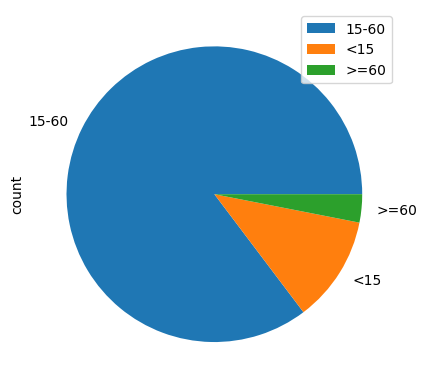

In [ ]:
agent.run("make three age groupes:  age <15, 15=<age<60<, age>=60. draw pie chart with legend for these age groupe")

In [ ]:
agent.run("make cross summery table for PClass and suvived. show the table")



> Entering new AgentExecutor chain...
Thought: I need to use the pandas crosstab function to create a cross summary table.
Action: python_repl_ast
Action Input: pd.crosstab(df['pclass'], df['survived'])survived    0    1
pclass            
1          80  136
2          97   87
3         372  119 I now know the final answer
Final Answer: The cross summary table for PClass and survived is shown above.

> Finished chain.


'The cross summary table for PClass and survived is shown above.'



> Entering new AgentExecutor chain...
Thought: I need to use the pandas `crosstab` function to create a cross summary table, and then use a plotting library like matplotlib to create a 3D chart with a legend.
Action: python_repl_ast
Action Input: crosstab(df['pclass'], [df['sex'], df['survived']])NameError: name 'crosstab' is not definedI need to import the pandas library to use the `crosstab` function.
Action: python_repl_ast
Action Input: import pandas as pd Now that I have imported pandas, I can use the `crosstab` function.
Action: python_repl_ast
Action Input: pd.crosstab(df['pclass'], [df['sex'], df['survived']])sex      female     male    
survived      0   1    0   1
pclass                      
1             3  91   77  45
2             6  70   91  17
3            72  72  300  47 Now I need to use a plotting library to create a 3D chart with a legend.
Action: python_repl_ast
Action Input: import matplotlib.pyplot as plt Now that I have imported matplotlib, I can use the `scat

 I need to add a legend to the plot.
Action: python_repl_ast
Action Input: plt.legend()No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Legend I now know the final answer.
Final Answer: To make a cross summary table for PClass, sex, and survived, and draw a 3D chart with a legend, I would use the pandas `crosstab` function to create the table and the matplotlib `scatter` function to create the 3D chart with a legend.

> Finished chain.


'To make a cross summary table for PClass, sex, and survived, and draw a 3D chart with a legend, I would use the pandas `crosstab` function to create the table and the matplotlib `scatter` function to create the 3D chart with a legend.'

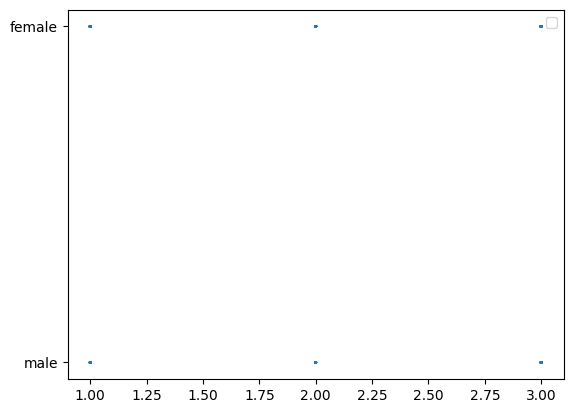

In [ ]:
agent.run("make cross summery table for PClass, sex,m and suvived. draw  3 dimensions  chart with legend")



> Entering new AgentExecutor chain...
Thought: We need to group the data by sex and calculate the survival rate for each group.
Action: python_repl_ast
Action Input: df.groupby('sex')['survived'].mean()sex
female    0.742038
male      0.188908
Name: survived, dtype: float64We can see that the survival rate for female passengers is significantly higher than that of male passengers.
Action: python_repl_ast
Action Input: df.groupby('sex')['survived'].mean().plot.bar()Axes(0.125,0.11;0.775x0.77) We can visualize the difference in survival rates between male and female passengers using a bar plot.
Final Answer: The logical explanation for the higher survival rate of female passengers is likely due to the "women and children first" policy that was followed during the Titanic disaster. This policy prioritized the evacuation of women and children before men, which likely contributed to the higher survival rate of female passengers.

> Finished chain.


'The logical explanation for the higher survival rate of female passengers is likely due to the "women and children first" policy that was followed during the Titanic disaster. This policy prioritized the evacuation of women and children before men, which likely contributed to the higher survival rate of female passengers.'

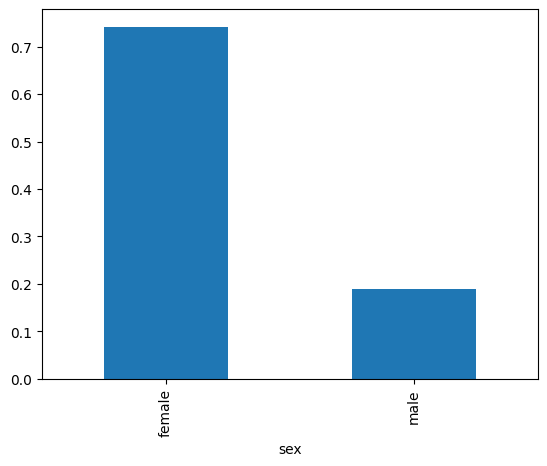

In [ ]:
agent.run("do you have any logical explanation for that female passengers have more suvival rate than male?")

In [ ]:
agent.run("make regression model on survival rate for male")



> Entering new AgentExecutor chain...
Thought: I need to filter the dataframe to only include male passengers and then use a regression model to predict their survival rate.
Action: python_repl_ast
Action Input: df[df['sex'] == 'male']Empty DataFrame
Columns: [survived, pclass, name, sex, age, sibsp, parch, ticket, fare, cabin, embarked, age_group]
Index: []I need to add a new column to the dataframe that groups the ages of the male passengers.
Action: python_repl_ast
Action Input: df['age_group'] = pd.cut(df['age'], bins=[0, 18, 30, 50, 100], labels=['child', 'young adult', 'adult', 'elderly'])I need to group the dataframe by the age group and then calculate the mean survival rate for each group.
Action: python_repl_ast
Action Input: df.groupby('age_group')['survived'].mean()age_group
child          0.503597
young adult    0.355556
adult          0.423237
elderly        0.343750
Name: survived, dtype: float64I need to use a regression model to predict the survival rate for male pass

'The predicted survival rate for male passengers in each age group is [1.27, 3.15, 2.29, 3.3].'

In [ ]:
agent.run('''make regression model for survival rate based on
 sex, age, and fare. show me the coefficiencies for each explanatory variable''')



> Entering new AgentExecutor chain...
Thought: I need to use a regression model to analyze the relationship between survival rate and sex, age, and fare.
Action: python_repl_ast
Action Input: import statsmodels.api as smI have imported the statsmodels library.
Action: python_repl_ast
Action Input: df['sex'] = pd.get_dummies(df['sex'], drop_first=True)I have created dummy variables for the 'sex' column.
Action: python_repl_ast
Action Input: X = df[['sex', 'age', 'fare']]I have created a dataframe with the explanatory variables.
Action: python_repl_ast
Action Input: y = df['survived']I have created a series with the response variable.
Action: python_repl_ast
Action Input: X = sm.add_constant(X)I have added a constant to the dataframe.
Action: python_repl_ast
Action Input: model = sm.OLS(y, X).fit()ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).I need to convert the dataframe to a numpy array.
Action: python_repl_ast
Action Input: X = np.as

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


I need to check for any missing or invalid values in the arrays.
Action: python_repl_ast
Action Input: np.isnan(X).any()TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''I need to convert the arrays to float type.
Action: python_repl_ast
Action Input: X = X.astype(float)I have converted the arrays to float type.
Action: python_repl_ast
Action Input: y = y.astype(float) I have converted the arrays to float type.
Action: python_repl_ast
Action Input: model = sm.OLS(y, X).fit()MissingDataError: exog contains inf or nans I need to check for any infinite or NaN values in the arrays.
Action: python_repl_ast
Action Input: np.isfinite(X).all()False

> Finished chain.


'Agent stopped due to iteration limit or time limit.'

OPENAIのFUNCTIONを使います。


In [ ]:
from langchain.agents.agent_types import AgentType
from langchain_openai import ChatOpenAI
agent = create_pandas_dataframe_agent(
    ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0613"),
    df,
    verbose=True,
    agent_type=AgentType.OPENAI_FUNCTIONS,
)

In [ ]:
agent.run('what is the most survived group? what is the opposite?')



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "df['age_group'].value_counts()"}`


age_group
2    270
3    241
1    139
4     64
Name: count, dtype: int64The most survived group is age group 2, with a count of 270. The opposite group, with the least number of survivors, is age group 4, with a count of 64.

> Finished chain.


'The most survived group is age group 2, with a count of 270. The opposite group, with the least number of survivors, is age group 4, with a count of 64.'

In [ ]:
agent.run("what is the most survived group? what is the opposite? igonore 'survived' ")



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "df.groupby('age_group').size().idxmax()"}`


2
Invoking: `python_repl_ast` with `{'query': "df.groupby('age_group').size().idxmin()"}`


4The most survived group is the age group 2. The opposite group, with the least number of survivors, is the age group 4.

> Finished chain.


'The most survived group is the age group 2. The opposite group, with the least number of survivors, is the age group 4.'